In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

# Load the dataset
data = pd.read_csv("glass.csv")

## 1. Data Exploration
print("Data Exploration")
print("\nDataset shape:", data.shape)
print("\nFirst 5 rows:")
print(data.head())
print("\nData types:\n", data.dtypes)
print("\nMissing values:\n", data.isnull().sum())
print("\nClass distribution:\n", data['type'].value_counts())

# 2. Data Preprocessing
data = data.drop('idno', axis=1)
data = data.drop_duplicates()
print("\nShape after removing duplicates:", data.shape)

X = data.iloc[:, 1:-1]
y = data.iloc[:, -1]

Data Exploration

Dataset shape: (214, 11)

First 5 rows:
   idno       RI     Na    Mg    Al     Si     K    Ca   Ba   Fe  type
0     1  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0     1
1     2  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0     1
2     3  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.0     1
3     4  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.0     1
4     5  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.0     1

Data types:
 idno      int64
RI      float64
Na      float64
Mg      float64
Al      float64
Si      float64
K       float64
Ca      float64
Ba      float64
Fe      float64
type      int64
dtype: object

Missing values:
 idno    0
RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
type    0
dtype: int64

Class distribution:
 type
2    76
1    70
7    29
3    17
5    13
6     9
Name: count, dtype: int64

Shape after removing duplicates: (213, 10)


In [78]:
# a. Univariate selection
bestfeatures = SelectKBest(score_func=chi2, k=5)
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Feature', 'Score']
print("\nTop 5 features using Univariate Selection:")
top5_uni = featureScores.nlargest(5, 'Score')
print(top5_uni)


Top 5 features using Univariate Selection:
  Feature       Score
6      Ba  144.659991
1      Mg  100.728772
4       K   31.485097
2      Al   16.602047
0      Na    4.335113



Top 5 features using Feature Importance:
Mg    0.192729
Al    0.167743
Ca    0.149309
K     0.129072
Na    0.112727
dtype: float64


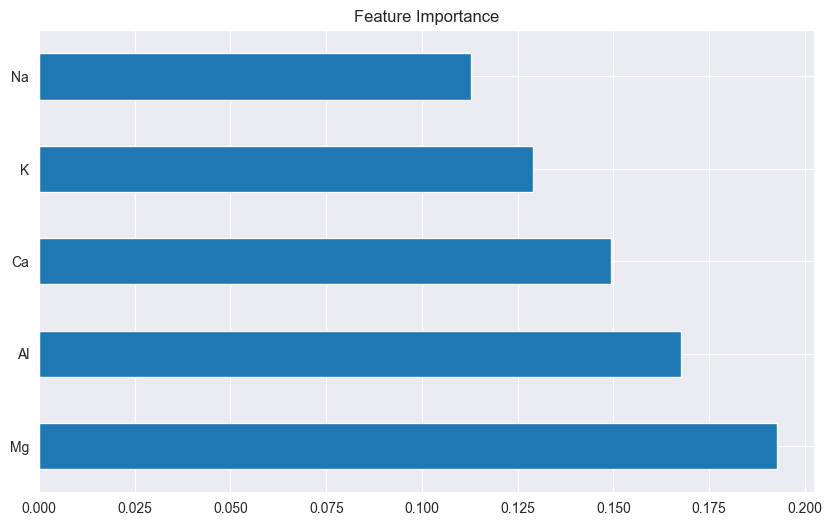

In [79]:
# b. Feature importance
model = ExtraTreesClassifier(random_state=10)
model.fit(X, y)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
top5_imp = feat_importances.nlargest(5)
print("\nTop 5 features using Feature Importance:")
print(top5_imp)

# Plot feature importance
plt.figure(figsize=(10,6))
feat_importances.nlargest(5).plot(kind='barh')
plt.title("Feature Importance")
plt.show()


Top 5 features using Correlation:
  Feature  Correlation
0      Mg     0.744195
1      Al     0.597432
2      Ba     0.574896
3      Na     0.508837
4      Fe     0.191090


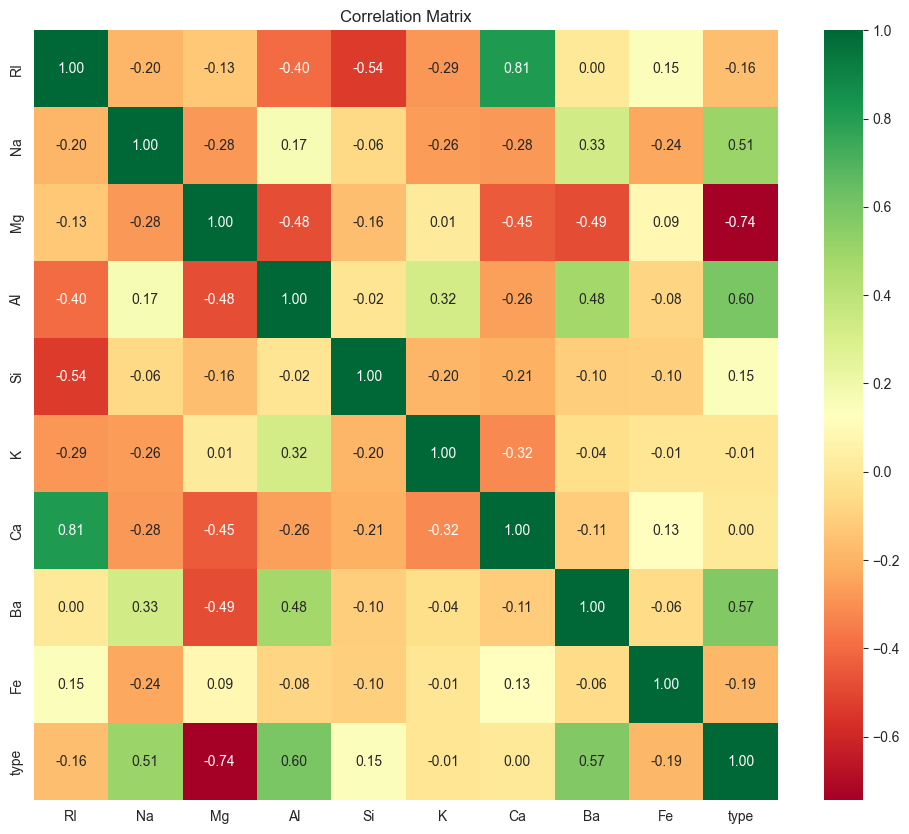

In [80]:
# c. Correlation
corr_data = pd.concat([X, y], axis=1)
corrmat = corr_data.corr()
top_corr = corrmat['type'].abs().sort_values(ascending=False).head(6)
top_corr = top_corr.drop('type')
top5_corr = pd.DataFrame({'Feature': top_corr.index, 'Correlation': top_corr.values})
print("\nTop 5 features using Correlation:")
print(top5_corr)

# Plot correlation
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), annot=True, cmap="RdYlGn", fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

In [82]:
# 4. Model development and evaluation
def evaluate_model(X, y, features_used="All features"):
    print(f"\nEvaluating model with {features_used}:")

    # Split data (80-20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

    # Create and train model
    model = GaussianNB()
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # 8-fold cross validation
    cv_scores = cross_val_score(model, X, y, cv=8)
    print(f"\n8-fold CV Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

In [83]:
# Evaluate with all features
evaluate_model(X, y)

# Evaluate with top 5 features from univariate selecyion
X_uni = X[top5_uni['Feature'].values]
evaluate_model(X_uni, y, "Top 5 Univariate features")

# Evaluate with top 5 features from Importance Features
X_imp = X[top5_imp.index]
evaluate_model(X_imp, y, "Top 5 Feature Importance features")

# Evaluate with top 5 features from Correlation
X_corr = X[top5_corr['Feature'].values]
evaluate_model(X_corr, y, "Top 5 Correlation features")


Evaluating model with All features:
Accuracy: 0.4418604651162791

Classification Report:
              precision    recall  f1-score   support

           1       0.53      0.71      0.61        14
           2       0.20      0.07      0.10        15
           3       0.17      0.33      0.22         3
           5       0.17      0.33      0.22         3
           6       0.50      0.50      0.50         2
           7       1.00      0.83      0.91         6

    accuracy                           0.44        43
   macro avg       0.43      0.46      0.43        43
weighted avg       0.43      0.44      0.41        43


8-fold CV Accuracy: 0.4265 (+/- 0.1518)

Evaluating model with Top 5 Univariate features:
Accuracy: 0.3953488372093023

Classification Report:
              precision    recall  f1-score   support

           1       0.47      0.64      0.55        14
           2       0.17      0.07      0.10        15
           3       0.00      0.00      0.00         3
      